In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigsh
from scipy.sparse import identity as sid
%matplotlib inline

In [2]:
def secant_method(f,x0,x1,tol):
    f0 = f(x0)
    f1 = f(x1)
    x2 = x1 - f1*(x1-x0)/(f1-f0)
    while np.abs(x2-x1)>=tol:
        x0 = x1
        x1 = x2
        f0 = f1
        f1 = f(x1)
        x2 = x1 - f1*(x1-x0)/(f1-f0)
    return x2

# DUE 12/11/19

**Problem 1**: (10pts) In quantum mechanics, it is really common to see boundary value problems of the form 

$$
-\epsilon\frac{d^{2}y}{dx^2} + |x|y = Ey, ~ y(-1) = 0, ~ y(1)=0.
$$

where $0\leq \epsilon \ll 1$, i.e. we let $\epsilon$ be a small positive parameter.  $E\geq 0$ is the _energy_ of a particle trapped in a potential well $V(x) = |x|$, which is formed by using two interferring electric fields.  We desribe the probability of a particle being in the interval $[-1,a]$, $a<1$ via the formula

$$
P(-1\leq x \leq a) = \int_{-1}^{a} \tilde{y}(x), ~ \tilde{y}(x) = \frac{y^{2}(x)}{\int_{-1}^{1}y^{2}(x)dx}
$$

1a) Using second-order centered-difference approximations and spdiags, write code which discretizes the operator $-\epsilon\frac{d^{2}y}{dx^2} + |x|y\approx A{\bf y}$, where ${\bf y}=\left(y_{1} ~y_{2}\cdots y_{N-1}\right)^{T}$, $y_{j}=y(x_{j})$.

1b) You have now formed a discrete eigenvalue problem $A{\bf y} = E{\bf y}$.  Using the code below find the first 10 eigenvalues of the discretized equations.  For $\epsilon=1,.1,.01$ and $.001$, describe via a well designed plot how the first ten energy levels change as you decrease $\epsilon$.  This is known in the literature as a _semi-classical limit_.

1c) For $\epsilon=.01$, compare the associated probability distributions $\tilde{y}(x)$ for the first three energy levels.  How do the likelihoods of where a particle would be found change with changing energy?   

\begin{align}
&-\epsilon y''(x)+|x|y=Ey 
\\
&\delta x = \frac{b-a}{N} 
\\
& j = 0,...,N
\\\\
y''(x_j) &\approx \frac{y(x_{j-1})-2y(x_j)+y(x_{j+1})}{(\delta x)^2}
\\
A{\bf y} &\approx -\epsilon y''(x_j)+|x_j|y(x_j)
\\
& = \frac{-\epsilon y(x_{j-1})+2\epsilon y(x_j)-\epsilon y(x_{j+1})}{(\delta x)^2}+|x_j|y(x_j)
\\
& =-\frac{\epsilon}{(\delta x)^2}y(x_{j-1})+\frac{2\epsilon}{(\delta x)^2}y(x_j)-\frac{\epsilon}{(\delta x)^2}y(x_{j+1})+|x_j|y(x_j)
\\
& = -\frac{\epsilon}{(\delta x)^2}y(x_{j-1})+\left(\frac{2\epsilon}{(\delta x)^2}+|x_j|\right)y(x_j)-\frac{\epsilon}{(\delta x)^2}y(x_{j+1})
\end{align}

$$A{\bf y} \approx
\begin{pmatrix} 
\frac{2\epsilon}{(\delta x)^2}+|x_1| & -\frac{\epsilon}{(\delta x)^2}
\\
-\frac{\epsilon}{(\delta x)^2} 
& \frac{2\epsilon}{(\delta x)^2}+|x_2| & -\frac{\epsilon}{(\delta x)^2}
\\
 &&\ddots 
 \\
& & -\frac{\epsilon}{(\delta x)^2} 
& \frac{2\epsilon}{(\delta x)^2}+|x_{N-2}| 
& -\frac{\epsilon}{(\delta x)^2}
\\
& & & -\frac{\epsilon}{(\delta x)^2} 
& \frac{2\epsilon}{(\delta x)^2}+|x_{N-1}|
\end{pmatrix} +
\begin{pmatrix} 
y_1 \\ 
y_2 \\ 
\vdots \\ 
y_{N-2} \\ 
y_{N-1} 
\end{pmatrix}$$

In [4]:
#1A

def findY( a, b, Nvals, fvals, yn1, y1, epsilon, xvals):
    Nint = int(Nvals)
    dx = (b-a)/Nvls
    idx2 = 1/(dx**2)
    edx2 = -epsilon*idx2
   
    rhs = fvals[1:Nint]
    rhs[0] -= yn1*idx2
    rhs[Nint-2] -= y1*idx2
   
    diag = -2.*edx2*np.ones(Nint-1)
    adiag = np.ones(Nvals-1) 
    for j in range(0,Nvals-2):
        adiag[j] *= np.abs(xvals[j+1])
        diag[j] += adiag[j]
    odiag = edx2*np.ones(Nint-1)
    data = np.array([diag,odiag,odiag])
    dvals = np.array([0,-1,1])
    Amat = spdiags(data, dvals, Nint-1, Nint-1)
    yvec = spsolve(Amat,rhs)
   
    return yvec

In [5]:
#1B

def eval_find(Nvls,xvals,epvl):
    Nint = int(Nvls)
    dx = (xvals[Nint]-xvals[0])/Nint
    idx2 = 1./(dx*dx)
    
    diag = -2*epvl*idx2 * np.ones(Nint - 1)+ np.abs(xvals[1:Nint])
    odiag = epvl*idx2*np.ones(Nint-1)
    data = np.array([diag,odiag,odiag])
    dvals = np.array([0,-1,1])
    Amat = spdiags(data, dvals, Nint-1, Nint-1)
    eigenvalues, eigenvectors = eigsh(Amat,10,which='SM',mode='buckling')  
   
    return eigenvalues 

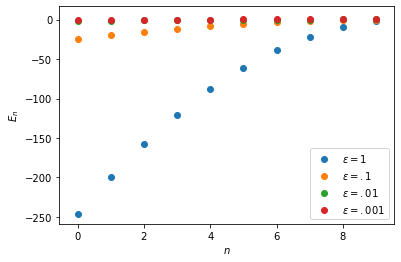

In [7]:
Nvls = 2000
xvals = np.linspace(-1.,1.,Nvls+1)

tprofile1 = eval_find(Nvls,xvals,1)
plt.scatter(np.arange(tprofile1.size),tprofile1[0:2001],label="$\epsilon=1$")
plt.xlabel("$n$")
plt.ylabel("$E_{n}$")

tprofile2 = eval_find(Nvls,xvals,.1)
plt.scatter(np.arange(tprofile2.size),tprofile2[0:2001],label="$\epsilon=.1$")

tprofile3 = eval_find(Nvls,xvals,.01)
plt.scatter(np.arange(tprofile3.size),tprofile3[0:2001],label="$\epsilon=.01$")

tprofile4 = eval_find(Nvls,xvals,.001)
plt.scatter(np.arange(tprofile4.size),tprofile4[0:2001],label="$\epsilon=.001$")

plt.legend(loc="best")

## Differential Equations in Time: A crash course

So, differential equations are equations involving a derivative.  They can be scalar problems like

$$
\frac{dy}{dt} = f(y,t), ~ y(t_{0}) = y_{0}
$$

or vector problems like

$$
\frac{d{\bf y}}{dt} = {\bf F}({\bf y},t), ~ {\bf y}(t_{0}) = {\bf y}_{0} \in \mathbb{R}^{n}.
$$

The condition $y(t_{0}) = y_{0}$ is called an _initial condition_.  

Some differential equations are easy to solve.  For example, if I ask you to solve 

$$
\frac{dy}{dt} = \lambda y, ~ y(t_{0}) = y_{0},
$$

we see almost by inspection that $y(t) = y_{0}e^{\lambda(t-t_{0})}$ solves the problem.  We can find this solution more systematically by seperating the equation.  In other words, we take 

$$
\frac{dy}{dt} = \lambda y,
$$

and turn it into 

$$
\frac{dy}{y} = \lambda dt.
$$

We then integrate both sides in the following way

$$
\int\frac{d y}{y} = \lambda\int dt.
$$

so that we find

$$
\ln\left|y(t)\right| = \lambda t + C,
$$

or 

$$
y(t) = \tilde{C}e^{\lambda t}, ~ \tilde{C} = e^{C}.
$$

Using the initial condition gives us $\tilde{C}=y_{0}e^{-\lambda t_{0}}$ and thus we have $y(t) = y_{0}e^{\lambda(t-t_{0})}$.

In general however, this trick does not work for very many differential equations of interest.  For example, the differential equation

$$
\frac{dy}{dt} = \cos(ty), ~ y(t_{0}) = y_{0},
$$

does not allow for separation between $y$ and $t$ since they are coupled inside the $\cos(ty)$ term.  

Thus, we turn to numerics.  Suppose I want a solution to the scalar initial-value problem 

$$
\frac{dy}{dt} = f(y,t), ~ y(t_{0}) = y_{0}
$$

for $t_{0}\leq t$.  I can then discretize the time so that I can try to interpolate my solution $y(t)$ at the discrete times $t_{j} = t_{0} + j\delta t$, $j=0,1,\cdots$.  Thus, if we work between the times $t_{n}$ and $t_{n+1} = t_{n} + \delta t$, we see that 

$$
\int_{t_{n}}^{t_{n+1}}\frac{dy}{dt}dt = \int_{t_{n}}^{t_{n+1}}f(y(t),t) dt,
$$

and so by integrating the left side and rearranging, we have that 

$$
y_{n+1} = y_{n} + \int_{t_{n}}^{t_{n+1}}f(y(t),t) dt,
$$

where $y_{n} = y(t_{n})$ and $y_{n+1} = y(t_{n+1})$.  Thus, by using different interpolatory approximations to the integral, we find different discretizations of the differential equation.  For example

* $f(y(t),t)\approx f(y_{n},t_{n})$ so $\int_{t_{n}}^{t_{n+1}}f(y(t),t) dt \approx \delta t f(y_{n},t_{n})$.

* $f(y(t),t)\approx f(y_{n+1},t_{n+1})$ so $\int_{t_{n}}^{t_{n+1}}f(y(t),t) dt \approx \delta t f(y_{n+1},t_{n+1})$.

* $f(y(t),t)\approx \frac{f(y_{n+1},t_{n+1})-f(y_{n},t_{n})}{\delta t}(t-t_{n}) + f(y_{n},t_{n})$, so $\int_{t_{n}}^{t_{n+1}}f(y(t),t) dt \approx \frac{\delta t}{2} \left( f(y_{n+1},t_{n+1}) + f(y_{n},t_{n})\right)$.

We then get the following methods for numerically solving the differential equation

* Foward Euler's Method: $y_{n+1} = y_{n} + \delta t f(y_{n},t_{n})$.
* Backward Euler's Method: $y_{n+1} = y_{n} + \delta t f(y_{n+1},t_{n+1})$.
* Trapezoid Method: $y_{n+1} = y_{n} + \frac{\delta t}{2}\left(f(y_{n},t_{n}) + f(y_{n+1},t_{n+1})\right)$.

The first method is called _explicit_ since we can find $y_{n+1}$ in terms of $y_{n}$ directly, whereas the next two methods are called _implicit_ since we have to solve for $y_{n+1}$ at each time step in order to move the method forward.  Thus, the implicit methods need a root finder in order to work in general.  See the code below for implementations of both Forward and Backward Euler in order to solve 

$$
\frac{dy}{dt} = \cos(ty), ~ y(0) = 10,
$$

for $0\leq t \leq 10$.

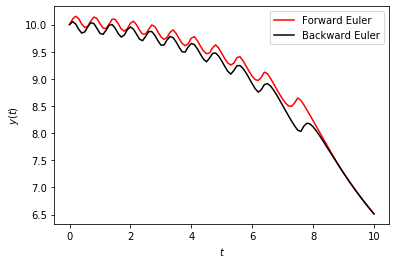

In [9]:
def forward_euler(f,dt,t0,tf,y0):
    nsteps = int(np.round((tf-t0)/dt))
    ysol = np.zeros(nsteps+1)
    times = np.zeros(nsteps+1)
    ysol[0] = y0
    times[0] = t0
    for jj in range(1,nsteps+1):
        ysol[jj] = ysol[jj-1] + dt*f(times[jj-1],ysol[jj-1])
        times[jj] = times[jj-1] + dt
    return np.array([times,ysol])

def backward_euler(f,dt,t0,tf,y0):
    nsteps = int(np.round((tf-t0)/dt))
    ysol = np.zeros(nsteps+1)
    times = np.zeros(nsteps+1)
    ysol[0] = y0
    times[0] = t0
    for jj in range(1,nsteps+1):
        times[jj] = times[jj-1] + dt
        floc = lambda y: (y-ysol[jj-1])-dt*f(times[jj],y)
        ysol[jj] = secant_method(floc,ysol[jj-1]/2.,ysol[jj-1],1e-6) # Note, we need a root finder for the implicit scheme.
    return np.array([times,ysol])

myf = lambda t,y: np.cos(t*y)
t0 = 0.
tf = 10.
y0 = 10.

dt = .1
feuler_sol = forward_euler(myf,dt,t0,tf,y0)
beuler_sol = backward_euler(myf,dt,t0,tf,y0)

plt.plot(feuler_sol[0][:],feuler_sol[1][:],color='r',label="Forward Euler")
plt.plot(beuler_sol[0][:],beuler_sol[1][:],color='k',label="Backward Euler")
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.legend(loc='best')

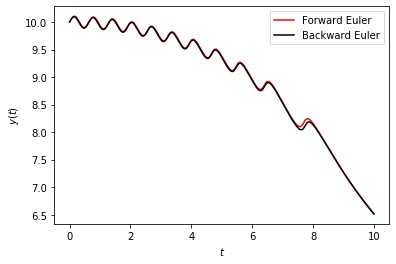

In [10]:
dt = .01
feuler_sol = forward_euler(myf,dt,t0,tf,y0)
beuler_sol = backward_euler(myf,dt,t0,tf,y0)

plt.plot(feuler_sol[0][:],feuler_sol[1][:],color='r',label="Forward Euler")
plt.plot(beuler_sol[0][:],beuler_sol[1][:],color='k',label="Backward Euler")
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.legend(loc='best')

Looking at our examples then, we see that we get markedly different results when we choose $\delta t = .01$ vs $\delta t = .1$.  Overall, we see that the change in the Forward Euler method is far more dramatic as we decrease the step size than for the Backward Euler method.  Thus, while the Backward Euler method is more computationally intensive since we need to use a root finder to update the method at each time step, we also can get away with using a much larger time step.   

**Problem 2**: (10 pts)

2a) Implement the Trapezoid method and then compare the results from the Forward Euler, Backward Euler, and Trapezoid Method for the test problem
$$
\frac{dy}{dt} = \lambda y, ~ y(0) = 1, ~ 0\leq t \leq 1.
$$
Develop test cases for $\lambda < 0$ and $\lambda >0$.  Using the exact solution described above, determine the order of error of each method.  Describe the behavior of the solutions and their accuracy as you vary $\delta t$ in the different methods.  Note, for this problem, we see that we do not need a root finder for the implicit schemes since 

Backward Euler: $y_{n+1} = y_{n}+\delta t \lambda y_{n+1}$ so $y_{n+1} = \frac{y_{n}}{1-\lambda \delta t} = \left(\frac{1}{1-\lambda \delta t} \right)^{n+1}y_{0}$

Trapezoid: $y_{n+1} = y_{n}+\frac{\lambda\delta t}{2} \left(y_{n+1}+y_{n}\right)$ so $y_{n+1} = \frac{1+\lambda \delta t/2}{1-\lambda \delta t/2}y_{n} = \left(\frac{1+\lambda \delta t/2}{1-\lambda \delta t/2} \right)^{n+1}y_{0}$.

2b) For the differential equation 
$$
\frac{dy}{dt} = \cos(y), ~ y(0) = 10, ~ 0\leq t \leq 10,
$$
find an exact solution using the fact that the problem is seperable. Then solve it using the Trapezoid Method.  Again, determine the order of error of the method and comment on how the numerical solution changes with step size $\delta t$. 

2c) For the differential equation
$$
\frac{dy}{dt} = \cos(ty), ~ y(0) = 10, ~ 0\leq t \leq 10,
$$
solve it using the Trapezoid method.  How does your solution compare in behavior to that you found in $2b$?  Explore several choices of step size $\delta t$ and determine the relative strengths and weaknesses of all three different approaches. In particular, which method allows for the largest time step $\delta t$ such that you get believable results?



In [11]:
#2A

def trapezoid_method(a,b,N,f):
    Nint = int(N)
    xvals = np.linspace(a,b,Nint+1)    
    fvals = f(xvals)  
    dx = (b-a)/N
    return dx/2.*(fvals[0]+fvals[Nint]+2.*np.sum(fvals[1:Nint]))

nl_func = lambda t: np.exp(-t)
print("trapezoid method for lambda = -1: %f"%trapezoid_method(0,1,1e3,nl_func))
d_nl_func = lambda t,y: -y
print(forward_euler(d_nl_func,.001,0,1,1))
print(backward_euler(d_nl_func,.001,0,1,1))

pl_func = lambda t: np.exp(t)
print()
print("trapezoid method for lambda = 1: %f"%trapezoid_method(0,1,1e3,pl_func))
d_pl_func = lambda t,y: y
print(forward_euler(d_pl_func,.001,0,1,1))
print(backward_euler(d_pl_func,.001,0,1,1))

trapezoid method for lambda = -1: 0.632121
[[0.00000000e+00 1.00000000e-03 2.00000000e-03 ... 9.98000000e-01
  9.99000000e-01 1.00000000e+00]
 [1.00000000e+00 9.99000000e-01 9.98001000e-01 ... 3.68431920e-01
  3.68063488e-01 3.67695425e-01]]
[[0.00000000e+00 1.00000000e-03 2.00000000e-03 ... 9.98000000e-01
  9.99000000e-01 1.00000000e+00]
 [1.00000000e+00 9.99000999e-01 9.98002996e-01 ... 3.68799799e-01
  3.68431368e-01 3.68063304e-01]]

trapezoid method for lambda = 1: 1.718282
[[0.00000000e+00 1.00000000e-03 2.00000000e-03 ... 9.98000000e-01
  9.99000000e-01 1.00000000e+00]
 [1.00000000e+00 1.00100000e+00 1.00200100e+00 ... 2.71149822e+00
  2.71420972e+00 2.71692393e+00]]
[[0.00000000e+00 1.00000000e-03 2.00000000e-03 ... 9.98000000e-01
  9.99000000e-01 1.00000000e+00]
 [1.00000000e+00 1.00100100e+00 1.00200300e+00 ... 2.71420565e+00
  2.71692257e+00 2.71964222e+00]]


In [15]:
#2B)

def trapezoid_method1(a,b,N,f):
    Nint = int(N)
    xvals = np.linspace(a,b,Nint+1)    
    fvals = f(xvals,Nint)  
    dx = (b-a)/N
    return dx/2.*(fvals[0]+fvals[Nint]+2.*np.sum(fvals[1:Nint]))

myf = lambda t,y: np.cos(t*y)
t0 = 0.
tf = 10.
y0 = 10.
t = trapezoid_method1(t0,tf,y0,myf)
print("Trapezoid for cos(ty):  %0.15f" %t)

Trapezoid for cos(ty):  0.074894748311143


2B)

\begin{align}
\frac{dy}{dt} = \cos(y)
\\
\frac{dy}{\cos(y)} &= dt
\\
\int \sec(y)dy &= \int dt
\\
\ln| \tan(y)+ \sec(y) | &= t + C_{1}
\\
\tan(y)+ \sec(y) &= Ce^{t} \quad \text{with }C = e^{C_{1}}
\\
\frac{\sin(y) +  1}{\cos (y)} &= Ce^{t}
\\
\left( \sin(y) +  1 \right)^{2} &= \left( Ce^{t}\cos(y) \right)^{2}
\\
\sin^{2}(y) + 2\sin(y) + 1 &= C^{2}e^{2t} \left( 1-\sin^{2}(x) \right)
\\
\sin^{2}(y) + 2\sin(y) + 1 &=C^{2}e^{2t} -  C^{2}e^{2t}\sin^{2}(x)
\\
\left( 1+C^{2}e^{2t} \right)\sin^{2}(y) + 2\sin(y) + \left( 1 - C^{2}e^{2t} \right) &= 0 
\\
y &= \sin^{-1}\left(\frac{-2 \pm \sqrt{ 4C^{4}e^{4t}} }{2+2C^{2}e^{2t}}\right) \quad C =\sec(10)+\tan(10)
\\
\end{align}

**Problem 3**: (10 pts) A more realistic way to describe the dynamics of temperature in a narrow corridor is via the _heat equation_, which is a partial differential equation describing how the temperature $T(x,t)$ changes in both space and time.  It is given by

$$
\frac{\partial T}{\partial t} = k \frac{\partial^{2}T}{\partial x^{2}}, ~ a\leq x \leq b
$$

where $k>0$ is the _thermal diffusion_ coefficient, and where we have the _insulating_ boundary conditions 

$$
\left.\frac{\partial T(x,t)}{\partial x}\right|_{x=a} = \left.\frac{\partial T(x,t)}{\partial x}\right|_{x=b} = 0, 
$$

and the initial temperature distribution

$$
T(x,0) = u(x).
$$

By insulating, we mean that no heat escapes through the lateral walls at $x=a$ and $x=b$.  To numerically solve this, letting $x_{j}= a + j\delta x$, $\delta x = (b-a)/N$

3a) Letting $T_{j}(t)=T(x_{j},t)$, show that the insulating boundary conditions are approximated by the finite-difference approximations:
$$
T_{0}(t) = \frac{2}{3}\left(2T_{1}(t)-\frac{1}{2}T_{2}(t)\right), ~ T_{N}(t) = \frac{2}{3}\left(2T_{N-1} - \frac{1}{2}T_{N-2}(t)\right).  
$$
(Note, see Homework Ten).  
3b) Using second-order centered-differencing approximations for the $\partial^{2}T/\partial{x^{2}}$ term, show that by discretizing in space, you get the following initial value problem

$$
\frac{d{\bf T}}{dt} = kA{\bf T}, ~ {\bf T}(t) = \begin{pmatrix} T_{1}(t) \\ T_{2}(t) \\ \cdots \\ T_{N-1}(t)\end{pmatrix}, ~ {\bf T}(0) = \begin{pmatrix} u(x_{1}) \\ u(x_{2}) \\ \cdots \\ u(x_{N-1})\end{pmatrix}
$$

where $A$ is some $(N-1)\times (N-1)$ sparse matrix.  What is $A$?  Is $A$ still symmetric?   

3c) Using the Trapezoid Method, we can discretize in time so that if we use time step $\delta t$, we get 

$$
\left(I - \frac{\delta t k}{2} A\right){\bf T}_{m+1} = \left(I + \frac{\delta t k}{2} A\right){\bf T}_{m},
$$

where 

$$
{\bf T}_{m} = {\bf T}(t_{m}) = \begin{pmatrix} T(x_{1},t_{m}) \\ T(x_{2},t_{m}) \\ \cdots \\ T(x_{N-1},t_{m})\end{pmatrix}
$$

Using the code snippet below implement the above scheme to solve the heat equation.  Using the initial heat distribution

$$
u(x) = e^{-(x-5)^{2}}, ~ 0\leq x \leq 10,
$$

generate several plots which show for $0\leq t \leq 10$ how changing the thermal diffusion paramter $k$ from $k=1,10,100$ changes the behavior of the temperature.  Explain your results and comment on any interesting phenomena. 

In [ ]:
def heat_eq_solver(k,u0,Nvls,dx,dt,t0,tf):    
    nsteps = int(np.round((tf-t0)/dt))
    Tsol = np.zeros((Nvls-1,nsteps+1)) # build a matrix to store our solution 
    Tsol[:,0] = u0
    idx2 = 1./(dx**2.)
    diag = -2.*np.ones(Nvls-1)
    udiag = np.ones(Nvls-1)
    ldiag = np.ones(Nvls-1)
    diag[0] = # what goes here?
    diag[Nvls-2] = # what goes here?
    udiag[1] = # what goes here?
    ldiag[Nvls-3] = # what goes here?
    data = np.array([diag,ldiag,udiag])
    dvals = np.array([0,-1,1])
    Amat = idx2*spdiags(data, dvals, Nvls-1, Nvls-1)
    Lp = sid(Nvls-1) + dt*k*Amat/2.
    Lm = sid(Nvls-1) - dt*k*Amat/2.
    for mm in range(0,nsteps):
        Tsol[:,mm+1] = spsolve(Lm,Lp*Tsol[:,mm])
    return Tsol

Nvls = int(1e2)
xvals = np.linspace(0.,10.,Nvls+1)
xvalsc = xvals[1:Nvls]
dx = 10./Nvls
dt = 1e-1
t0 = 0.
tf = 10.
k = 1.
NT = int(np.round(tf/dt))

u0 = np.exp(-(xvals[1:Nvls]-5.)**2.)
Tsol = heat_eq_solver(k,u0,Nvls,dx,dt,t0,tf)

plt.subplot(2,1,1)
plt.plot(xvalsc,Tsol[:,0])
plt.xlabel('$x$')
plt.ylabel('$T(x,0)$')

plt.subplot(2,1,2)
plt.plot(xvalsc,Tsol[:,99])
plt.xlabel('$x$')
plt.ylabel('$T(x,t_{f})$')

plt.tight_layout()

\begin{align}
T_{xx}(x_j,t) &\approx \frac{1}{(\delta x)^2}(T(x_{j-1},t)-2T(x_j,t)+T(x_{j+1},t))
\end{align}

$$A \approx \frac{1}{(\delta x)^2}
\begin{pmatrix}
-2 & 1 
\\
1 & -2 
\\
& & \ddots 
\\
& & & -2 & 
\\
& & & 1 & -2 
\end{pmatrix} 
= \begin{pmatrix} 
\frac{-2}{(\delta x)^2} & \frac{1}{(\delta x)^2}
\\
\frac{1}{(\delta x)^2} & \frac{-2}{(\delta x)^2}
\\
& & \ddots 
\\
& & & \frac{-2}{(\delta x)^2} & \frac{1}{(\delta x)^2}
\\
& & & \frac{1}{\delta x)^2} & \frac{-2}{(\delta x)^2}
\end{pmatrix}
$$
A is still Symmetric
<br>
$$
\frac{dT}{dt} \approx k \begin{pmatrix}\frac{-2}{(\delta x)^2} & \frac{1}{(\delta x)^2} & & & \\
\frac{1}{(\delta x)^2} & \frac{-2}{(\delta x)^2} & & & \\
& & \ddots & & \\
& & & \frac{1}{(\delta x)^2} \frac{-2}{(\delta x)^2}
\end{pmatrix}
\begin{pmatrix} T_1(t) \\ T_2(t) \\ \vdots \\ T_{N-1}(t) 
\end{pmatrix} = \begin{pmatrix}\frac{-2k}{(\delta x)^2} & \frac{k}{(\delta x)^2} & & & \\
\frac{k}{(\delta x)^2} & \frac{-2k}{(\delta x)^2} & & & \\
& & \ddots & & \\
& & & \frac{k}{(\delta x)^2} \frac{-2k}{(\delta x)^2}
\end{pmatrix}
\begin{pmatrix} T_1(t) \\ T_2(t) \\ \vdots \\ T_{N-1}(t) 
\end{pmatrix}, T(0) = \begin{pmatrix} u(x_1) \\ u(x_2) \\ \vdots \\u(x_2) \end{pmatrix}
$$

\begin{align}
T_{0,m} 
&= \frac{2}{3}(2T_{1,m}-\frac{1}{2}T_{2,m})
\\
T_{xx}(x_1,t) 
&= \frac{1}{(\delta x)^2}(T_{0,m}-2T_{1,m}+T_{2,m}) 
\\
&= \frac{1}{(\delta x)^2}(\frac{2}{3}[2T_{1,m}-\frac{1}{2}T_{2,m}]-2T_{1,m}+T_{2,m}) 
\\
&= \frac{1}{(\delta x)^2}(\frac{4}{3}T_{1,m}-{1}{3}T_{2,m}-2T_{1,m}+T_{2,m}) 
\\
&= \frac{1}{(\delta x)^2}(-\frac{2}{3}T_{1,m}+\frac{2}{3}T_{2,m})
\end{align}

In [1]:
print('hi')

hi


In [2]:
2+2

4